# Dask Bag (2)

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Макрушин С.В. Лекция "Map-Reduce"
* https://docs.dask.org/en/latest/bag.html
* Jesse C. Daniel. Data Science with Python and Dask. 
* https://realpython.com/python-reduce-function/
* https://docs.python.org/3/library/calendar.html

## Задачи для совместного разбора

In [1]:
import dask.bag as db
import json
from functools import reduce

In [3]:
with open("posts.json") as fp:
    posts = json.load(fp)
posts_bag = db.from_sequence(posts, npartitions=2)

1. Посчитайте суммарную длину длин описаний постов

In [5]:
sum(len(post['title']) for post in posts)

3952

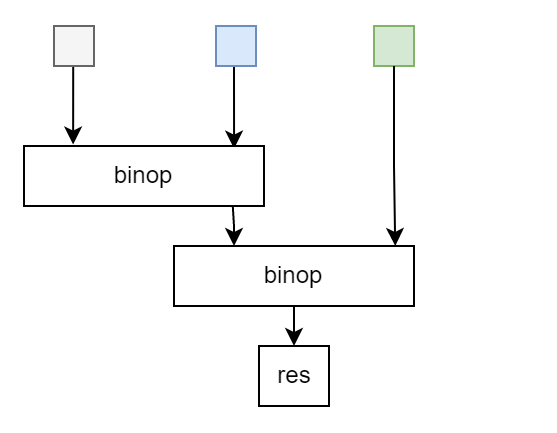

In [8]:
reduce(
    lambda acc, val: acc + val,
    map(
        lambda p: len(p['title']),
        posts
    ),
    -1000
)

2952

In [9]:
titles = posts_bag.map(lambda p: len(p['title']))
titles.take(1)

(74,)

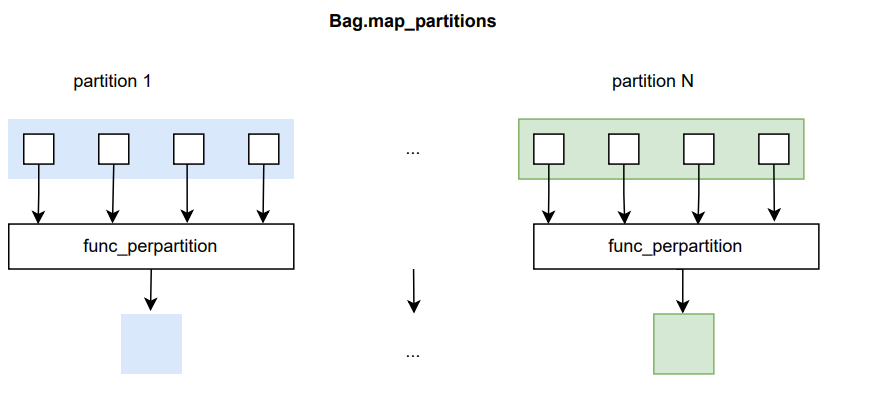

In [10]:
titles

dask.bag<lambda, npartitions=2>

In [11]:
def f(partitions):
    return sum(partitions)

titles.map_partitions(f).compute()

(1944, 2008)

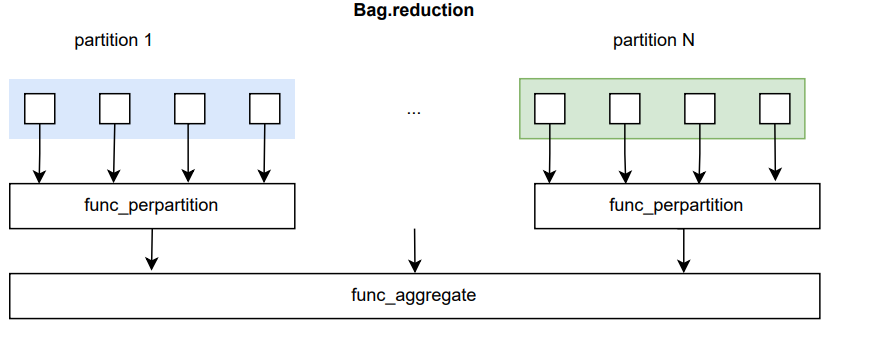

In [12]:
def func_preparation(partitions):
    return sum(partitions)

def func_aggregate(partition_results):
    return sum(partition_results)

titles.reduction(func_preparation, func_aggregate).compute()

3952

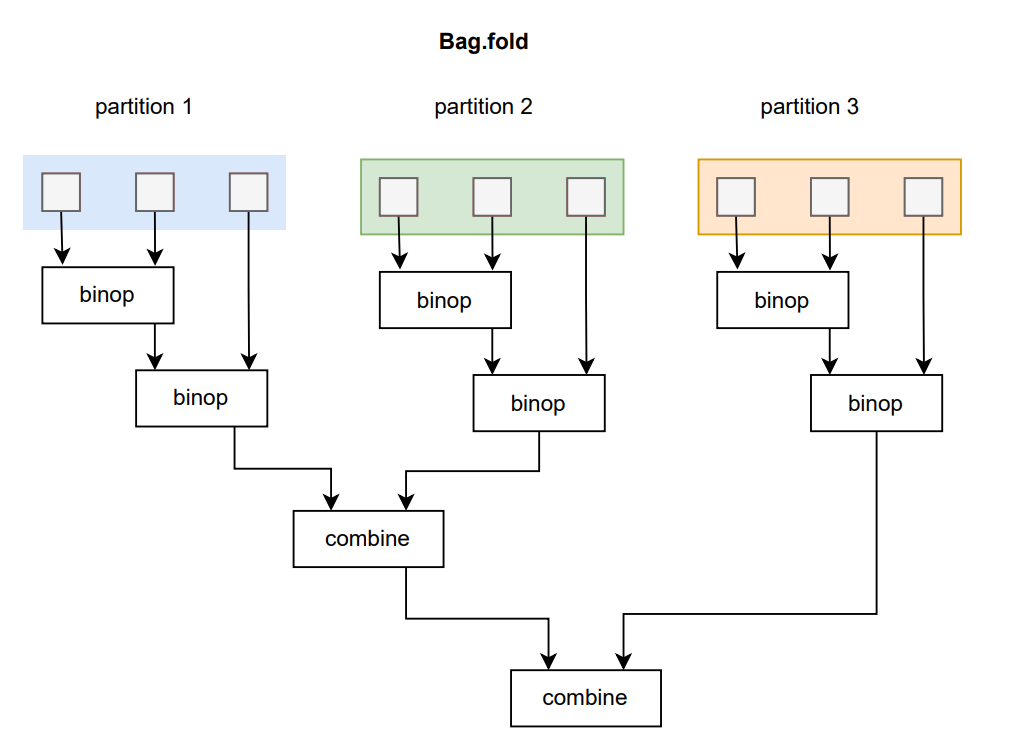

In [16]:
titles.fold(
    binop=lambda acc, val: acc + val,
    #combine=lambda acc, val: acc + val
).compute()

3952

2. При помощи метода `foldby` посчитайте, сколько постов написал каждый из пользователей.

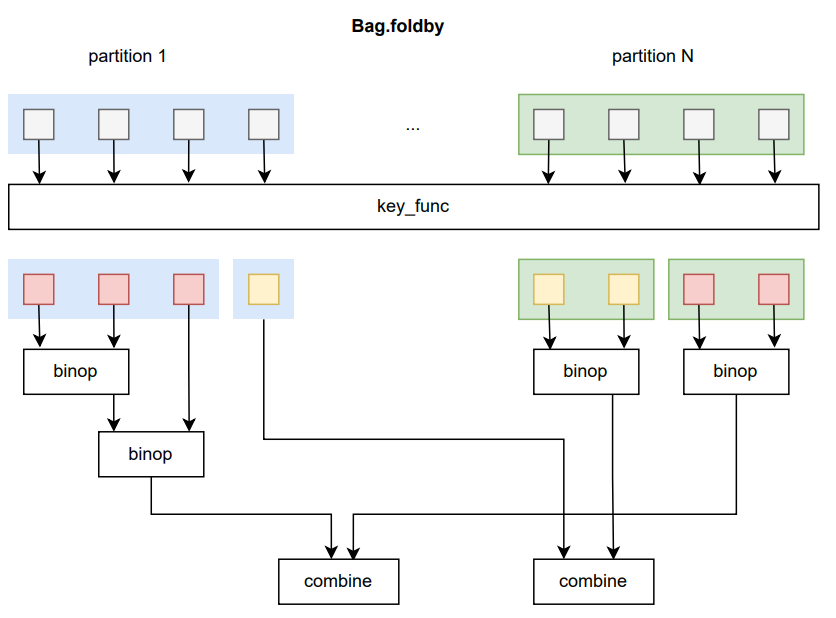

In [22]:
posts_bag.foldby(
    key=lambda p: p['userId'],
    binop=lambda acc, val: acc + 1,
    initial=0,
    combine=lambda acc, val: acc + val,
    combine_initial=0
).compute()

[(1, 10),
 (2, 10),
 (3, 10),
 (4, 10),
 (5, 10),
 (6, 10),
 (7, 10),
 (8, 10),
 (9, 10),
 (10, 10)]

## Лабораторная работа 10

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy`, `pandas` и `dask`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy`, структур `pandas` или структур `dask` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

В ходе выполнения все операции вычислений проводятся над `dask.bag` и средствами пакета `dask`, если в задании не сказано обратного. Переход от `dask.bag` к любым другим структурам возможен исключительно для демонстрации результата в конце решения задачи. Если в задаче используются результаты выполнения предыдущих задач, то подразумевается, что вы используете результаты в виде `dask.bag` (то есть то, что было получено до вызова `compute`, а не после).

<p class="task" id="1"></p>

1\. Загрузите отзывы из файла `reviews_1.json` в виде списка. Используя `functools.reduce`, сгенерируйте словарь, содержащий частоты слов, встречающихся в отзывах из этого файла. Для разбиения на слова используйте объект `tokenizer`. Перед разбиением на слова приведите текст отзыва к нижнему регистру. Выведите на экран длину полученного словаря.


In [1]:
import json
from nltk.tokenize import RegexpTokenizer
from functools import reduce
tokenizer = RegexpTokenizer(r'\w+')

In [2]:
with open('reviews_1.json', 'r') as f:
    reviews = [json.loads(line) for line in f]

In [3]:
reviews = [review['review'].lower() for review in reviews if review['review'] is not None]

In [4]:
def update_frequencies(frequencies, review):
    words = tokenizer.tokenize(review)
    for word in words:
        frequencies[word] = frequencies.get(word, 0) + 1
    return frequencies

In [5]:
frequencies = reduce(update_frequencies, reviews, {})

In [6]:
print(len(frequencies))

41570


<p class="task" id="2"></p>

2\. Общее количество символов, которое занимает слово во всех отзывах, можно рассчитать, умножив длину этого слова на частоту использования этого слова. Используя `functools.reduce`, найдите слово, которое занимает больше всего символов в отзывах из файла `reviews_1.json` (воспользуйтесь результатами из задачи 1). Выведите найденное слово и количество занимаемых им символов на экран. Решите ту же задачу при помощи функции `max`.

In [7]:
max_word = reduce(lambda x, y: x if len(x)*frequencies[x] >= len(y)*frequencies[y] else y, frequencies.keys())

print("Больше всего символов в отзывах занимает слово:", max_word)
print("Количество занимаемых символов:", len(max_word)*frequencies[max_word])

Больше всего символов в отзывах занимает слово: the
Количество занимаемых символов: 711756


In [8]:
max_word = max(frequencies.keys(), key=lambda x: len(x)*frequencies[x])

print("Больше всего символов в отзывах занимает слово:", max_word)
print("Количество занимаемых символов:", len(max_word)*frequencies[max_word])

Больше всего символов в отзывах занимает слово: the
Количество занимаемых символов: 711756


<p class="task" id="3"></p>

3\. Будем считать, что сегмент _плохо перемешан_, если в нем _подряд_ идет 5 или более отзывов, оставленных в один и тот же год. Воспользовавшись методом `Bag.map_partitions`, посчитайте и выведите на экран, сколько сегментов оказались _плохо перемешанными_ в `reviews_bag`. 

In [9]:
import dask.bag as db
import json

reviews_bag = db.read_text(
    "reviews_full/*.json", blocksize="128MiB"
).map(json.loads)

In [10]:
reviews_bag.npartitions

25

In [11]:
# Функция для проверки, является ли сегмент плохо перемешанным
def is_bad_segment(segment):
    bad = 0  # флаг, который устанавливается, если сегмент плохо перемешан
    count = 0  # количество отзывов подряд в один и тот же год
    year = ''  # текущий год
    for review in segment:
        # если год текущего отзыва совпадает с годом предыдущего отзыва, увеличиваем счетчик
        if review['date'][:4] == year:
            count += 1
        else:
            # если год текущего отзыва отличается от года предыдущего отзыва
            # и количество отзывов подряд в предыдущем году больше либо равно 5,
            # устанавливаем флаг bad в 1
            year = review['date'][:4]
            if count >= 5:
                bad = 1
            count = 1  # сбрасываем счетчик для нового года
    return bad

In [12]:
reviews_bag.map_partitions(
    lambda partition: (is_bad_segment(partition), )
).sum().compute()

17

<p class="task" id="4"></p>

4\. Будем считать, что сегмент _плохо перемешан_, если в нем подряд идет 5 или более отзывов, оставленных в один и тот же год. Воспользовавшись методом `Bag.reduction`, посчитайте и выведите на экран, сколько сегментов оказались _плохо перемешанными_ в `reviews_bag`.

In [13]:
reviews_bag.reduction(
    lambda partition: is_bad_segment(partition),
    lambda partition_results: sum(partition_results),
).compute()

17

<p class="task" id="5"></p>

5\. Будем считать, что сегмент _плохо перемешан_, если в нем подряд идет 5 или более отзывов, оставленных в один и тот же год. Воспользовавшись методом `fold`, посчитайте и выведите на экран, сколько сегментов оказались _плохо перемешанными_ в `reviews_bag`.

Примечание 1: один из возможных вариантов реализации функции свертки заключается в использовании кортежей, содержащих год и кол-во раз, которое этот год встретился подряд.

Примечание 2: dask автоматически объединяет сегменты в группы размера `split_every`. Из-за этого во время шага `combine` могут возникнуть проблемы с типом входных данных. Вы можете упростить функцию `combine`, выставив достаточно большое значение `split_every`.

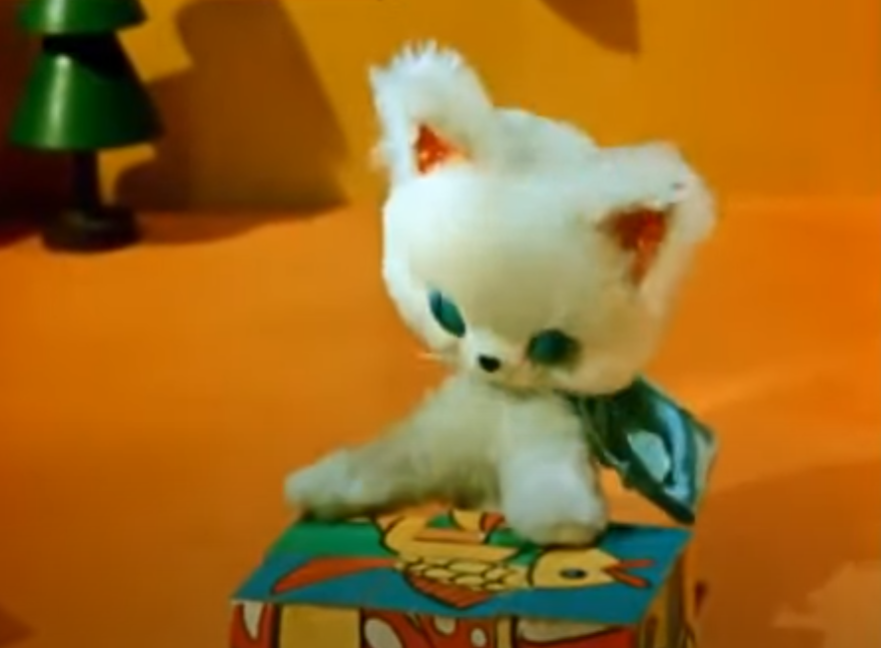

<p class="task" id="6"></p>

6\.  При помощи метода `accumulate` для каждого $i$-го отзыва расчитайте, столько отзывов из 2010 года было оставлено среди первых $i$ элементов. Воспользовавшись полученным результатом и расчитав общее количество элементов в `reviews_bag`, выберите `k` первых строк объекта `reviews_bag` таким образом, чтобы в выбранном множестве оказалось ровно 10 тыс. отзывов, оставленных в 2010 году. Подтвердите правильность решения, выведя количество элементов в выбранном множестве, которые были оставлены в 2010 году.

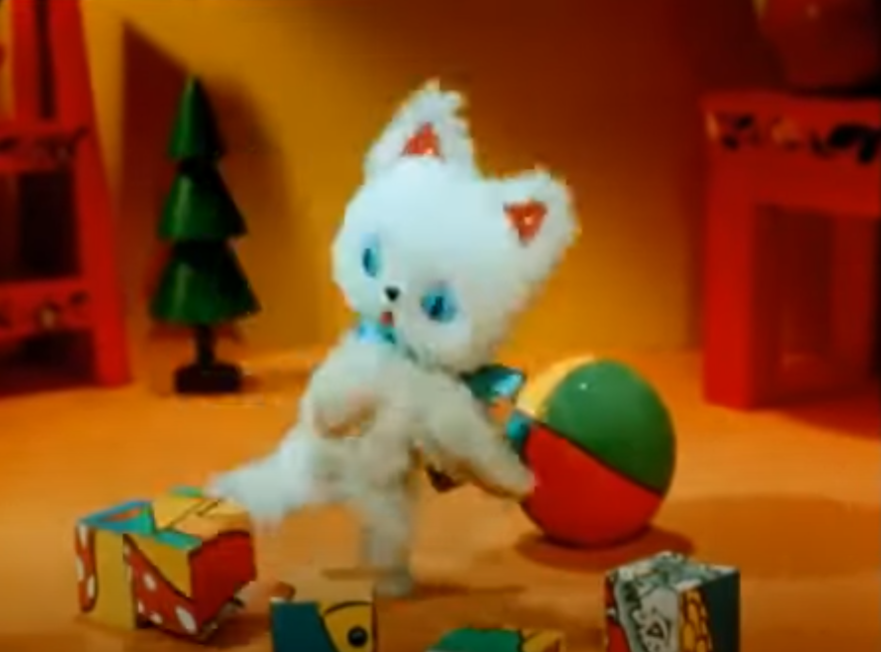

<p class="task" id="7"></p>

7\. Посчитайте, сколько отзывов оставили пользователи в каждом месяце каждого года. Создайте `pd.DataFrame`, у которого в качестве индексов строк указаны года, а в качестве имен столбцов - названия месяцев. Выведите полученную таблицу на экран. Выведите на экран строку за 2010 год. 

Для преобразования числа месяца в название вы можете воспользоваться пакетом [calendar](https://docs.python.org/3/library/calendar.html#calendar.month_name)

In [14]:
import dask.bag as db
import json
import pandas as pd
import calendar

reviews_bag = db.read_text(
    "reviews_full/*.json", blocksize="128MiB"
).map(json.loads)

In [15]:
def count_reviews(part):
    result = []
    for review in part:
        year_month = review['date'][:7]
        result.append((year_month, 1))
    return result

def merge_tuples(t1, t2):
    year_month, count = t2
    if year_month in t1:
        return (year_month, t1[year_month] + count)
    else:
        t1[year_month] = count
        return t1

def combine_dicts(d1, d2):
    result = d1.copy()
    for year_month, count in d2.items():
        result[year_month] = result.get(year_month, 0) + count
    return result

In [16]:
counts_bag = reviews_bag.map_partitions(count_reviews)
counts = counts_bag.foldby(lambda x: x[0], lambda a, b: (a[0], a[1] + b[1]), initial=(None, 0))
counts = counts.filter(lambda x: x[0] is not None).compute()

In [17]:
years = set([year_month[:4] for year_month, _ in counts])
months = [calendar.month_name[i] for i in range(1, 13)]
data = {year: {month: 0 for month in months} for year in years}
for year_month, count in counts:
    year, month = year_month[:4], calendar.month_name[int(year_month[5:])]
    data[year][month] += count[1]
df = pd.DataFrame(data).sort_index().T.sort_index()

In [18]:
df

,April,August,December,February,January,July,June,March,May,November,October,September
1970,57,151,224,24,16,134,98,48,88,188,197,131
1971,294,380,419,215,252,336,336,280,307,411,362,373
1972,504,586,668,454,439,569,525,520,527,635,630,565
1973,720,841,928,676,715,811,785,752,807,897,876,813
1974,943,1102,1131,900,932,1066,1031,985,1056,1115,1179,1112
1975,1162,1275,1405,1105,1081,1307,1268,1293,1271,1317,1424,1377
1976,1472,1541,1677,1439,1374,1558,1500,1497,1560,1625,1686,1510
1977,1743,1842,2035,1589,1663,1876,1730,1760,1802,1857,1920,1792
1978,1943,2146,2219,1805,1969,2094,2011,2103,2021,2201,2193,2052
1979,2270,2394,2481,2022,2265,2373,2338,2320,2235,2427,2477,2375


In [19]:
df.loc['2010']

April        32791
August       28009
December     29077
February     30675
January      35728
July         30057
June         33614
March        32592
May          32855
November     27878
October      28239
September    26905
Name: 2010, dtype: int64

<p class="task" id="8"></p>

8\. Используя метод `Bag.foldby`, подсчитайте и выведите на экран максимальную длину отзывов в зависимости от года в объекте `reviews_bag`.

In [20]:
def get_year(review):
    return review['date'][:4]

def get_max_review_length(acc, val):
    if val['review'] is not None:
        return max(acc, len(val['review']))
    else:
        return acc
    
def get_combined_max_review_length(acc, val):
    return max(acc, val)

result = reviews_bag.foldby(key=get_year, 
                            binop=get_max_review_length,
                            initial=0,
                            combine=get_combined_max_review_length,
                            combine_initial=0, ).compute()

result

[('2016', 4954),
 ('2006', 5567),
 ('1985', 3937),
 ('2019', 6972),
 ('1972', 2036),
 ('2014', 6972),
 ('2017', 5567),
 ('1978', 3717),
 ('2015', 6972),
 ('2009', 5567),
 ('1989', 4289),
 ('2004', 4566),
 ('2020', 6972),
 ('2010', 5567),
 ('2008', 6972),
 ('2013', 6972),
 ('2012', 8587),
 ('2021', 5799),
 ('1997', 4521),
 ('2018', 6972),
 ('2005', 8587),
 ('2000', 5799),
 ('2011', 4592),
 ('1994', 4289),
 ('1998', 4289),
 ('2001', 3535),
 ('2003', 5567),
 ('1980', 3219),
 ('1984', 4521),
 ('1992', 4521),
 ('2007', 5799),
 ('2002', 6972),
 ('1993', 6972),
 ('1990', 4521),
 ('1999', 3535),
 ('1977', 4396),
 ('1982', 5799),
 ('1995', 5799),
 ('1991', 4146),
 ('1988', 3535),
 ('1996', 8587),
 ('1987', 3779),
 ('1986', 3668),
 ('1979', 3562),
 ('1974', 3530),
 ('1981', 4954),
 ('1983', 3279),
 ('1976', 2433),
 ('1975', 3200),
 ('1971', 1866),
 ('1970', 1597),
 ('1973', 2665)]